In [1]:
# Run these in a Colab cell
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install decord
!pip install kagglehub
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-enr7w3x9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-enr7w3x9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... one
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369514 sha256=1dce63db13e24a2dde55ceac6e8a8e40831ab0c9643216e2c40fa675fa123031
  Stored in directory: /tmp/pip-ephem-wheel-cache-4xdjeu9g/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstall

In [2]:
import torch
import random
from PIL import Image
import numpy as np
import pandas as pd
import os
from decord import VideoReader, cpu

import kagglehub

import clip

from codecarbon import EmissionsTracker

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
# print(f"GPU name: {torch.cuda.get_device_name(0)}")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.6.0+cu124
CUDA available: True


In [3]:
# Download latest version
path = kagglehub.dataset_download("yash07yadav/project-data")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/yash07yadav/project-data/versions/1


In [4]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define multiple prompts for violence detection
violent_prompts = [
    "A brutal fight with multiple people engaged in violence.",
    "A person violently attacking another with punches and kicks.",
    "A chaotic fight scene with people punching and kicking each other."
]

non_violent_prompts = [
    "A peaceful gathering where people are standing and talking calmly.",
    "A person walking in a park with no conflict happening.",
    "An empty street with no visible fights or violence."
]

# Tokenize all prompts
text_inputs = clip.tokenize(violent_prompts + non_violent_prompts).to(device)

# Process frames
def classify_video(video_reader, frame_interval=10):
    violence_scores = []
    for i in range(0, len(video_reader), frame_interval):
        frame = video_reader[i].asnumpy()
        image = Image.fromarray(frame)
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(image_input, text_inputs)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
        violence_scores.append(probs[0])  # Probability of violence
    return np.mean(violence_scores)

100%|███████████████████████████████████████| 338M/338M [00:29<00:00, 12.1MiB/s]


In [5]:
tracker = EmissionsTracker(project_name="LVLM Video Classification")

# Define paths
fight_dir = path + "/Complete Dataset/train/Fight/"
non_fight_dir = path + "/Complete Dataset/train/NonFight/"

# Function to get video files from a directory
def get_video_paths(directory, label):
    video_files = [f for f in os.listdir(directory) if f.endswith(('.mp4', '.avi', '.mov'))]
    return [{"video_path": os.path.join(directory, f), "label": label} for f in video_files]

# Load both Fight and NonFight videos
fight_videos = get_video_paths(fight_dir, 1)  # Label 1 for Fight
non_fight_videos = get_video_paths(non_fight_dir, 0)  # Label 0 for NonFight

# Combine and shuffle
all_videos = fight_videos + non_fight_videos
random.shuffle(all_videos)  # Shuffle to mix fight and non-fight videos

tracker.start()

# Process all videos
results = []
for video in all_videos:
    video_path = video["video_path"]
    label = video["label"]

    try:
        vr = VideoReader(video_path, ctx=cpu(0))
        score = classify_video(vr)  # Your classification function
        results.append({
            "video_path": video_path,
            "label": label,
            "violence_score": score,
            "prediction": "Violent" if score > 0.5 else "NonViolent"
        })
    except Exception as e:
        print(f"Error processing {video_path}: {str(e)}")

emissions = tracker.stop()

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

[codecarbon INFO @ 14:51:26] [setup] RAM Tracking...
[codecarbon INFO @ 14:51:26] [setup] CPU Tracking...
[codecarbon WARNING @ 14:51:26] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon INFO @ 14:51:27] CPU Model on constant consumption mode: AMD EPYC 7513 32-Core Processor
[codecarbon INFO @ 14:51:27] [setup] GPU Tracking...
[codecarbon INFO @ 14:51:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:51:27] >>> Tracker's metadata:
[codecarbon INFO @ 14:51:27]   Platform system: Linux-6.8.0-55-generic-x86_64-with-glibc2.39
[codecarbon INFO @ 14:51:27]   Python version: 3.12.9
[codecarbon INFO @ 14:51:27]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 14:51:27]   Available RAM : 251.682 GB
[codecarbon INFO @ 14:51:27]   CPU count: 64
[codecarbon INFO @ 14:51:27]   CPU model: AMD EPYC 7513 32-Core Processor
[codecarbon INFO @ 14:51:27]   GPU count: 3
[code

                                             video_path  label  \
0     /home/jovyan/.cache/kagglehub/datasets/yash07y...      0   
1     /home/jovyan/.cache/kagglehub/datasets/yash07y...      1   
2     /home/jovyan/.cache/kagglehub/datasets/yash07y...      0   
3     /home/jovyan/.cache/kagglehub/datasets/yash07y...      1   
4     /home/jovyan/.cache/kagglehub/datasets/yash07y...      1   
...                                                 ...    ...   
1995  /home/jovyan/.cache/kagglehub/datasets/yash07y...      1   
1996  /home/jovyan/.cache/kagglehub/datasets/yash07y...      0   
1997  /home/jovyan/.cache/kagglehub/datasets/yash07y...      0   
1998  /home/jovyan/.cache/kagglehub/datasets/yash07y...      1   
1999  /home/jovyan/.cache/kagglehub/datasets/yash07y...      0   

      violence_score  prediction  
0           0.047516  NonViolent  
1           0.264648  NonViolent  
2           0.358887  NonViolent  
3           0.089172  NonViolent  
4           0.102539  NonViolent

/opt/conda/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
/opt/conda/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Accuracy: 0.4840

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.95      0.65      1000
           1       0.29      0.02      0.04      1000

    accuracy                           0.48      2000
   macro avg       0.39      0.48      0.34      2000
weighted avg       0.39      0.48      0.34      2000



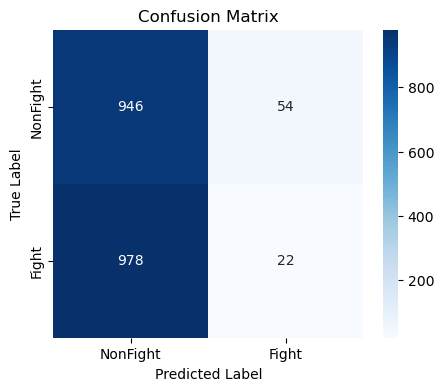

ROC-AUC Score: 0.4840


In [6]:
# Get true labels from the DataFrame
true_labels = results_df["label"].tolist()

# Predicted labels based on the violence score threshold (0.5)
pred_labels = [1 if row["prediction"] == "Violent" else 0 for _, row in results_df.iterrows()]

# Accuracy & Classification Report
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonFight", "Fight"], yticklabels=["NonFight", "Fight"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(true_labels, pred_labels)
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [7]:
# Get energy usage details
emissions = tracker.final_emissions_data.emissions
energy_consumed = tracker.final_emissions_data.energy_consumed
duration = tracker.final_emissions_data.duration
cpu_energy = tracker.final_emissions_data.cpu_energy
gpu_energy = tracker.final_emissions_data.gpu_energy
ram_energy = tracker.final_emissions_data.ram_energy

print(f"Emissions: {emissions:.4f} kWh")
print(f"Total Energy: {energy_consumed:.4f} kWh")
print(f"Duration: {duration:.2f} seconds")
print(f"CPU Energy: {cpu_energy:.4f} kWh")
print(f"GPU Energy: {gpu_energy:.4f} kWh")
print(f"RAM Energy: {ram_energy:.4f} kWh")

Emissions: 0.0172 kWh
Total Energy: 0.3061 kWh
Duration: 3559.40 seconds
CPU Energy: 0.0986 kWh
GPU Energy: 0.1145 kWh
RAM Energy: 0.0930 kWh
